In [1]:
!pip install DALL-E

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bs4 as bs
import requests
import cv2
import torch
from google.colab import drive
import PIL
import io

import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from IPython.display import display, display_markdown

from dall_e import map_pixels, unmap_pixels, load_model

In [3]:
target_image_size = 256

def png_to_jpg(img_path):
  im1 = PIL.Image.open(img_path)
  rgb_im1 = im1.convert('RGB')
  rgb_im1.save(str(img_path)[:-4] + '.jpg')

def download_image(url):
    return PIL.Image.open(url)

def preprocess(img):
    s = min(img.size)
    
    # if s < target_image_size:
    #     raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)

In [4]:
# This can be changed to a GPU, e.g. 'cuda:0'.
dev = torch.device('cpu')
print(dev)
drive.mount('/content/gdrive')

cuda:0
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
# read in images
from pathlib import Path
otaku_path = Path("/content/gdrive/MyDrive/otaku_database")

In [6]:
for category in ['Portrait', 'Game']:
  for image in otaku_path.glob(f"Otaku_*_{category}.png"):
    png_to_jpg(image)

In [7]:
# read in images
imgs = [preprocess(download_image(image)) for category in ['Portrait', 'Game'] for image in otaku_path.glob(f"Otaku_*_{category}.jpg")]
len(imgs)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:405: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


92

(426, 350, 3)

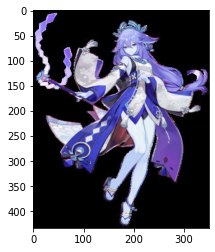

In [8]:
to_disp = [cv2.imread(str(image)) for category in ['Portrait', 'Game'] for image in otaku_path.glob(f"Otaku_*_{category}.jpg")]
plt.imshow(to_disp[0])
to_disp[1].shape

In [9]:
# For faster load times, download these files locally and use the local paths instead.
enc = load_model("https://cdn.openai.com/dall-e/encoder.pkl", dev)
dec = load_model("https://cdn.openai.com/dall-e/decoder.pkl", dev)


In [10]:
print(dec)

Decoder(
  (blocks): Sequential(
    (input): Conv2d(n_in=8192, n_out=128, kw=1, use_float16=False, device=device(type='cpu'), requires_grad=False)
    (group_1): Sequential(
      (block_1): DecoderBlock(
        (id_path): Conv2d(n_in=128, n_out=2048, kw=1, use_float16=True, device=device(type='cpu'), requires_grad=False)
        (res_path): Sequential(
          (relu_1): ReLU()
          (conv_1): Conv2d(n_in=128, n_out=512, kw=1, use_float16=True, device=device(type='cpu'), requires_grad=False)
          (relu_2): ReLU()
          (conv_2): Conv2d(n_in=512, n_out=512, kw=3, use_float16=True, device=device(type='cpu'), requires_grad=False)
          (relu_3): ReLU()
          (conv_3): Conv2d(n_in=512, n_out=512, kw=3, use_float16=True, device=device(type='cpu'), requires_grad=False)
          (relu_4): ReLU()
          (conv_4): Conv2d(n_in=512, n_out=2048, kw=3, use_float16=True, device=device(type='cpu'), requires_grad=False)
        )
      )
      (block_2): DecoderBlock(
    

In [11]:
z_logits = enc(imgs[0])

RuntimeError: ignored

In [ ]:
z = torch.argmax(z_logits, axis=1)
z = F.one_hot(z, num_classes=enc.vocab_size).permute(0, 3, 1, 2).float()

x_stats = dec(z).float()
x_rec = unmap_pixels(torch.sigmoid(x_stats[:, :3]))
x_rec = T.ToPILImage(mode='RGB')(x_rec[0])

display_markdown('Reconstructed image:')
display(x_rec)